# Data Science PBL 1 - Drug Discovery

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import vectorize as vec
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import scipy as sp
import sklearn


from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors,PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

## Read the dataset

In [2]:
df = pd.read_table('pGI50_mols.tsv')
df.head(3)

,Unnamed: 0,Washed_smiles,CCRF-CEM,HL-60(TB),K-562,MOLT-4,RPMI-8226,SR,A549/ATCC,EKVX,...,UO-31,PC-3,DU-145,MCF7,MDA-MB-231/ATCC,MDA-MB-468,HS 578T,MDA-N,BT-549,T-47D
0,1,CC1=CC(=O)C=CC1=O,5.5705,5.5405,5.441,5.4875,5.3855,5.4095,4.352,4.791,...,5.1075,4.785,4.756,4.8235,4.795,5.804,4.7225,NaN,4.809,5.281
1,17,CCCCCCCCCCCCCCCc1cc(ccc1N)O,7.3320,6.8470,4.970,6.7370,6.7450,5.6610,4.000,4.296,...,6.1640,6.334,4.000,4.6380,4.507,5.690,4.7690,NaN,6.516,6.578
2,26,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.4490,5.7660,5.777,5.5900,5.4290,5.7150,5.228,5.158,...,5.7640,5.365,4.997,4.9750,5.356,5.499,NaN,NaN,NaN,4.853


In [3]:
df.columns = df.columns.str.replace('Unnamed: 0', 'molecule_id')
df.head(3)

,molecule_id,Washed_smiles,CCRF-CEM,HL-60(TB),K-562,MOLT-4,RPMI-8226,SR,A549/ATCC,EKVX,...,UO-31,PC-3,DU-145,MCF7,MDA-MB-231/ATCC,MDA-MB-468,HS 578T,MDA-N,BT-549,T-47D
0,1,CC1=CC(=O)C=CC1=O,5.5705,5.5405,5.441,5.4875,5.3855,5.4095,4.352,4.791,...,5.1075,4.785,4.756,4.8235,4.795,5.804,4.7225,NaN,4.809,5.281
1,17,CCCCCCCCCCCCCCCc1cc(ccc1N)O,7.3320,6.8470,4.970,6.7370,6.7450,5.6610,4.000,4.296,...,6.1640,6.334,4.000,4.6380,4.507,5.690,4.7690,NaN,6.516,6.578
2,26,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.4490,5.7660,5.777,5.5900,5.4290,5.7150,5.228,5.158,...,5.7640,5.365,4.997,4.9750,5.356,5.499,NaN,NaN,NaN,4.853


## Data pre-processing of the bioactivity data

In [28]:
df2 = df[['molecule_id', 'Washed_smiles', 'SR']]
df2

,molecule_id,Washed_smiles,SR
0,1,CC1=CC(=O)C=CC1=O,5.4095
1,17,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610
2,26,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150
3,89,CN(C)CCC(=O)c1ccccc1,4.4550
4,112,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860
...,...,...,...
51173,780194,COc1ccc(cc1/C=C/C(=O)c2cc(c(c(c2)OC)OC)OC)C(=C...,6.3380
51174,780196,COc1ccc(cc1/C=C/C(=O)c2ccc(cc2)F)C(=O)c3cc(c(c...,5.6910
51175,780198,COc1ccc(cc1/C=C/C(=O)c2ccc3c(c2)OCO3)C(=C)c4cc...,6.0420
51176,783538,COc1ccc(cc1)[C@]23[C@@H]([C@H]([C@H]([C@]2(c4c...,8.4670


In [7]:
df2.isna().any()

molecule_id      False
Washed_smiles    False
SR                True
dtype: bool

In [29]:
df2 = df2.dropna()
df2

,molecule_id,Washed_smiles,SR
0,1,CC1=CC(=O)C=CC1=O,5.4095
1,17,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610
2,26,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150
3,89,CN(C)CCC(=O)c1ccccc1,4.4550
4,112,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860
...,...,...,...
51173,780194,COc1ccc(cc1/C=C/C(=O)c2cc(c(c(c2)OC)OC)OC)C(=C...,6.3380
51174,780196,COc1ccc(cc1/C=C/C(=O)c2ccc(cc2)F)C(=O)c3cc(c(c...,5.6910
51175,780198,COc1ccc(cc1/C=C/C(=O)c2ccc3c(c2)OCO3)C(=C)c4cc...,6.0420
51176,783538,COc1ccc(cc1)[C@]23[C@@H]([C@H]([C@H]([C@]2(c4c...,8.4670


In [30]:
df2.isna().any()

molecule_id      False
Washed_smiles    False
SR               False
dtype: bool

In [31]:
bioactivity_class = []
for i in df2.SR:
    if float(i) < 6:
        bioactivity_class.append("inactive")
    else:
        bioactivity_class.append("active")

In [32]:
bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
df3 = pd.concat([df2, bioactivity_class], axis=1)
df3

,molecule_id,Washed_smiles,SR,bioactivity_class
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active
...,...,...,...,...
51173,780194.0,COc1ccc(cc1/C=C/C(=O)c2cc(c(c(c2)OC)OC)OC)C(=C...,6.3380,NaN
51174,780196.0,COc1ccc(cc1/C=C/C(=O)c2ccc(cc2)F)C(=O)c3cc(c(c...,5.6910,NaN
51175,780198.0,COc1ccc(cc1/C=C/C(=O)c2ccc3c(c2)OCO3)C(=C)c4cc...,6.0420,NaN
51176,783538.0,COc1ccc(cc1)[C@]23[C@@H]([C@H]([C@H]([C@]2(c4c...,8.4670,NaN


A PROBLEM APPEARS HERE I DON'T KNOW WHY PYTHON NOT ABLE TO DEFINE THE CLASS FOR THE REST OF DATA

## Exploratory data analysis

In [33]:
df4 = pd.read_csv('cleaned.csv')
df4

,molecule_id,Washed_smiles,SR,bioactivity_class
0,1,CC1=CC(=O)C=CC1=O,5.4095,inactive
1,17,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive
2,26,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive
3,89,CN(C)CCC(=O)c1ccccc1,4.4550,inactive
4,112,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active
...,...,...,...,...
51173,780194,COc1ccc(cc1/C=C/C(=O)c2cc(c(c(c2)OC)OC)OC)C(=C...,6.3380,active
51174,780196,COc1ccc(cc1/C=C/C(=O)c2ccc(cc2)F)C(=O)c3cc(c(c...,5.6910,inactive
51175,780198,COc1ccc(cc1/C=C/C(=O)c2ccc3c(c2)OCO3)C(=C)c4cc...,6.0420,active
51176,783538,COc1ccc(cc1)[C@]23[C@@H]([C@H]([C@H]([C@]2(c4c...,8.4670,active


In [35]:
df4.isna().any()

molecule_id          False
Washed_smiles        False
SR                    True
bioactivity_class    False
dtype: bool

In [36]:
df4 = df4.dropna()

In [37]:
df4.isna().any()

molecule_id          False
Washed_smiles        False
SR                   False
bioactivity_class    False
dtype: bool

In [38]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):
    
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
        
    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:
        
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        
        row = np.array([desc_MolWt,
                       desc_MolLogP,
                       desc_NumHDonors,
                       desc_NumHAcceptors])
        
        if(i == 0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1
        
    columnNames = ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)
    
    return descriptors

## Convert SMILES to Molecule (ROMol)

In [39]:
Chem.PandasTools.AddMoleculeColumnToFrame(df4, smilesCol='Washed_smiles', molCol='ROMol')

/Users/alqaafsubando-m/opt/anaconda3/envs/pbl-1/lib/python3.7/site-packages/rdkit/Chem/PandasTools.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


### Random visualization

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol
1328,29459,COc1ccc(cc1CN(CCCl)CCCl)Nc2ccnc3c2ccc(c3)Cl,6.802,active,
1329,29466,CC(C)OC(=O)Nc1cccc(c1)Cl,4.000,inactive,
1332,29605,c1cc(ccc1n2cnc3c2nc(nc3N)N)Br,6.924,active,

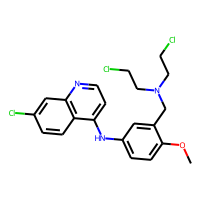
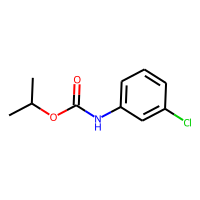
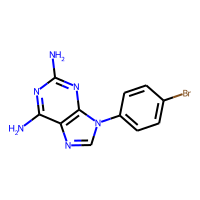

In [40]:
df4.iloc[1000:1003,:]

## Finding MW, LogP, NumHDonors, NumHAcceptors, using Lipinski Descriptor

In [41]:
df5 = lipinski(df4.Washed_smiles)
df5

,MW,LogP,NumHDonors,NumHAcceptors
0,122.123,0.64070,0.0,2.0
1,319.533,6.60810,2.0,2.0
2,398.287,5.84610,0.0,0.0
3,177.247,1.82100,0.0,2.0
4,206.353,3.12648,0.0,0.0
...,...,...,...,...
40904,520.578,5.70440,0.0,8.0
40905,450.462,4.98720,0.0,6.0
40906,474.509,5.40730,0.0,7.0
40907,654.665,1.57280,4.0,13.0


,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive,,122.123,0.64070,0.0,2.0
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive,,319.533,6.60810,2.0,2.0
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive,,398.287,5.84610,0.0,0.0
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive,,177.247,1.82100,0.0,2.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active,,206.353,3.12648,0.0,0.0
...,...,...,...,...,...,...,...,...,...
51173,780194.0,COc1ccc(cc1/C=C/C(=O)c2cc(c(c(c2)OC)OC)OC)C(=C...,6.3380,active,,NaN,NaN,NaN,NaN
51174,780196.0,COc1ccc(cc1/C=C/C(=O)c2ccc(cc2)F)C(=O)c3cc(c(c...,5.6910,inactive,,NaN,NaN,NaN,NaN
51175,780198.0,COc1ccc(cc1/C=C/C(=O)c2ccc3c(c2)OCO3)C(=C)c4cc...,6.0420,active,,NaN,NaN,NaN,NaN
51176,783538.0,COc1ccc(cc1)[C@]23[C@@H]([C@H]([C@H]([C@]2(c4c...,8.4670,active,,NaN,NaN,NaN,NaN

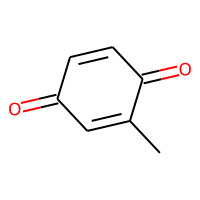
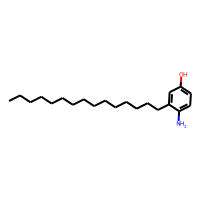
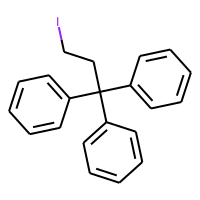
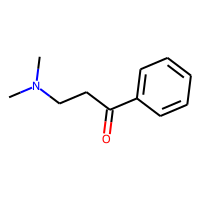
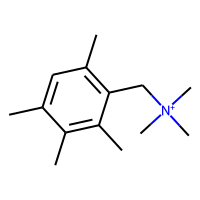
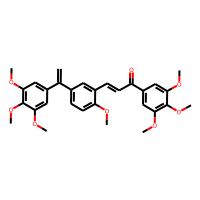
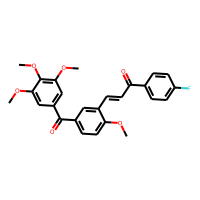
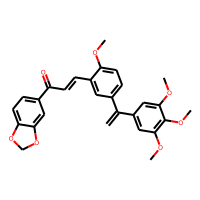
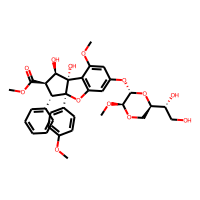
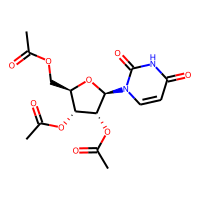

In [42]:
df6 = pd.concat([df4, df5], axis = 1)
df6

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive,,122.123,0.64070,0.0,2.0
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive,,319.533,6.60810,2.0,2.0
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive,,398.287,5.84610,0.0,0.0
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive,,177.247,1.82100,0.0,2.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active,,206.353,3.12648,0.0,0.0
...,...,...,...,...,...,...,...,...,...
40904,707041.0,c1cc(c(c(c1)Cl)C#N)Oc2ccc(cc2)S(=O)(=O)/N=C(/N...,4.6220,inactive,,520.578,5.70440,0.0,8.0
40905,707042.0,c1cc(c(c(c1)Cl)Oc2ccc(cc2)S(=O)(=O)/N=C(/Nc3cc...,5.2120,inactive,,450.462,4.98720,0.0,6.0
40906,707043.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,5.3960,inactive,,474.509,5.40730,0.0,7.0
40907,707044.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,4.9720,inactive,,654.665,1.57280,4.0,13.0

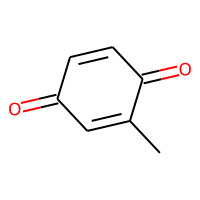
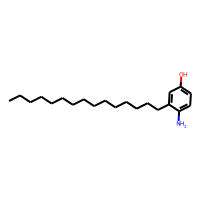
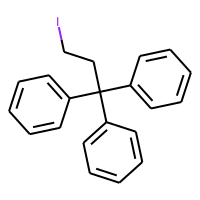
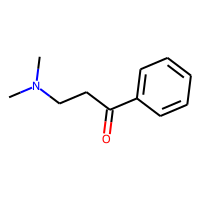
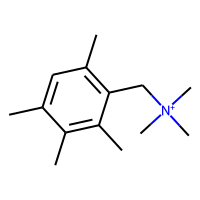
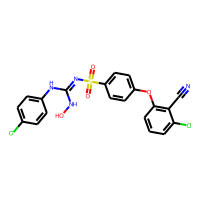
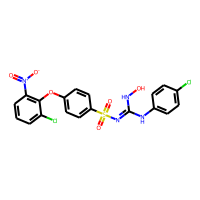
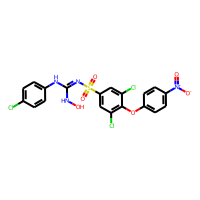
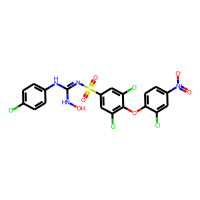
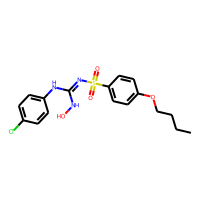

In [43]:
df6 = df6.dropna()
df6

In [44]:
df6.to_csv('lipinski_cleaned.csv')

## Frequency plot of the 2 bioactivity classes

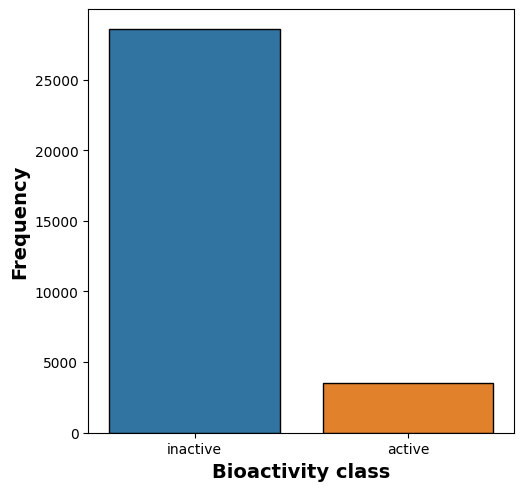

In [46]:
plt.figure(figsize = (5.5, 5.5))

sns.countplot(x = 'bioactivity_class', data = df6, edgecolor = 'black')

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')

plt.show()

## Scatter plot of MW versus LogP

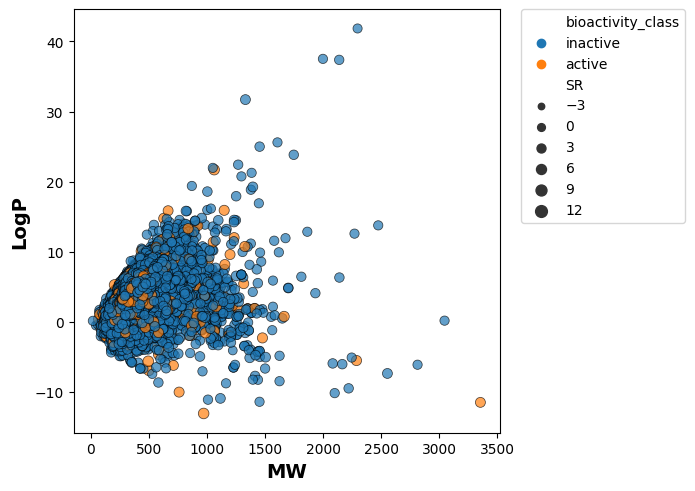

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df6, hue='bioactivity_class', size='SR', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.savefig('scatter_mwlogp.png')
plt.show()

## Scatter plot of NumHDonors versus NumHAcceptors

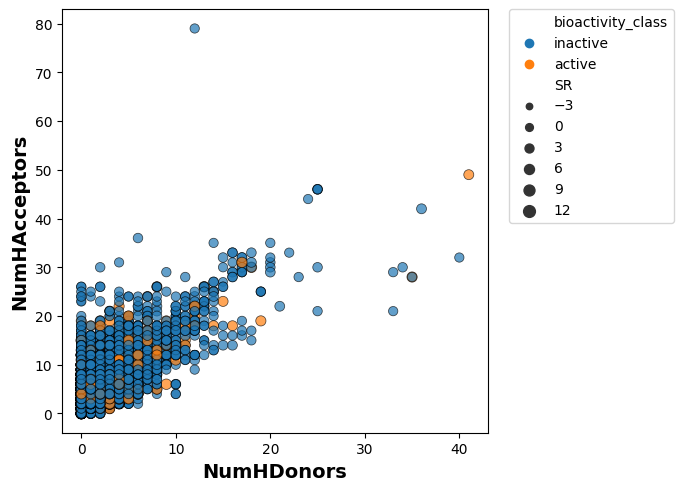

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='NumHDonors', y='NumHAcceptors', data=df6, hue='bioactivity_class', size='SR', edgecolor='black', alpha=0.7)

plt.xlabel('NumHDonors', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.savefig('scatter_donorsacceptors.png')
plt.show()

## Statistical Analysis with Mann-Whitney U Test

In [62]:
def mannwhitney(descriptor, data_frame, verbose=False):
    # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import mannwhitneyu
    
    # seed the random number generator
    seed(1)
    
    # actives and inactives
    selection = [descriptor, 'bioactivity_class']
    df = data_frame[selection]
    active = df[df['bioactivity_class'] == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df = data_frame[selection]
    inactive = df[df['bioactivity_class'] == 'inactive']
    inactive = inactive[descriptor]
    
    # compare samples
    stat, p = mannwhitneyu(active, inactive)
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'
        
    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    
    results.to_csv(filename)
    
    return results

### pGI50 or SR Value with Outlier

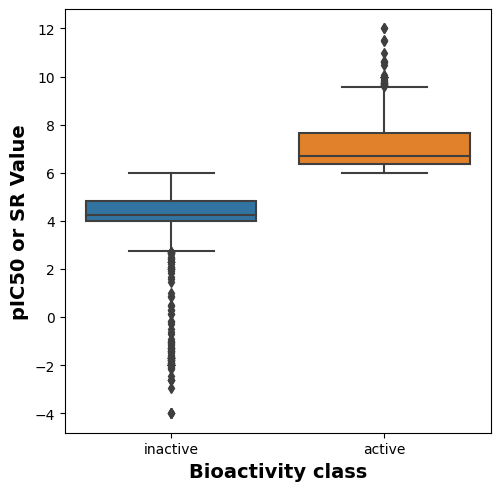

In [66]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'SR', data = df6)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('pIC50 or SR Value', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_sr.png')
plt.show()

### pGI50 or SR Value without Outlier

In [52]:
# Percentile 5% on lower limit
sr_low_limit = df6['SR'].quantile(0.05)
sr_low_limit

4.0

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
40,844.0,CC1=CCC(CC1)C(=C)C,3.5260,inactive,,370.408,4.84010,3.0,4.0
59,1390.0,c1c2c([nH]n1)nc[nH]c2=O,3.6595,inactive,,209.252,2.55240,2.0,3.0
86,1895.0,c1([nH]nc(n1)N)N,2.4810,inactive,,242.705,4.23610,0.0,1.0
109,2183.0,C(CCl)C(=O)O,2.8630,inactive,,230.563,1.88200,0.0,5.0
145,3051.0,CNC=O,2.0000,inactive,,192.218,0.73780,2.0,4.0
...,...,...,...,...,...,...,...,...,...
35085,689577.0,CCC(C)(CC(C)(C)C(=O)NCC(=O)NC(Cc1ccccc1)C(=O)N...,-1.0000,inactive,,367.323,3.80790,0.0,5.0
37103,695797.0,CC(=O)N[C@]12CC[C@H](C1)C(C2=O)(C)C,-2.0000,inactive,,327.336,2.91070,2.0,5.0
37238,696259.0,Cc1cc2c(cc1CN(CC#C)c3ccc(c(c3)F)C(=O)N[C@@H](C...,-1.1500,inactive,,596.692,1.64312,1.0,11.0
37327,696807.0,Cc1[nH]c(=O)c2cccc(c2n1)O,3.9430,inactive,,628.755,4.49692,3.0,8.0

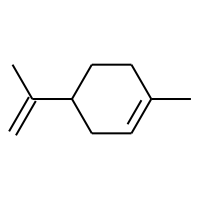
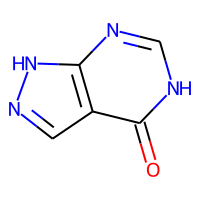
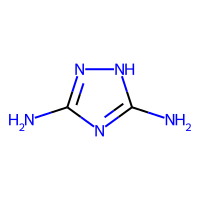
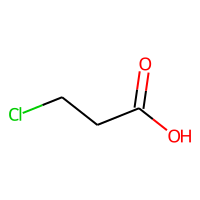
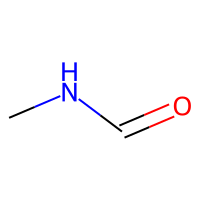
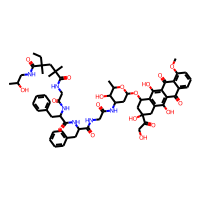
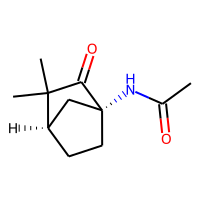
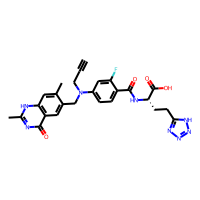
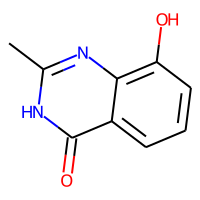
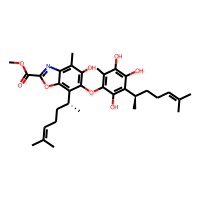

In [53]:
# Showing data below the lower limit
df6[df6['SR'] < sr_low_limit]

In [54]:
# Percentile 95% on upper limit
sr_up_limit = df6['SR'].quantile(0.95)
sr_up_limit

6.843999999999999

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
6,185.0,C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)...,7.3810,active,,281.352,1.04150,2.0,4.0
12,353.0,CCN(CC)CCCNc1c2ccc(cc2nc3c1cc(cc3)OC)Cl,7.5380,active,,371.912,5.19380,1.0,4.0
13,355.0,CCN(CC)CCCC(C)Nc1c(cnc2c1cc(c(c2)Cl)C)C,8.0000,active,,347.934,5.42744,1.0,3.0
27,739.0,c1cc(ccc1C(=O)NC(CCC(=O)O)C(=O)O)NCc2cnc3c(n2)...,8.0000,active,,246.306,-0.28100,0.0,6.0
28,740.0,CN(Cc1cnc2c(n1)c(nc(n2)N)N)c3ccc(cc3)C(=O)N[C@...,7.9695,active,,167.197,0.59769,3.0,4.0
...,...,...,...,...,...,...,...,...,...
40792,706462.0,Cc1ccc2c(=O)cc([nH]c2n1)c3csc4c3cccc4,8.0000,active,,447.344,2.91860,4.0,6.0
40797,706470.0,CN1CCN(CC1)C(=O)c2cn(cc2c3cccc4c3cccc4)Cc5cncn...,7.6260,active,,456.615,5.61436,2.0,5.0
40828,706743.0,COc1cc2c(cc1OC)c(=O)n(c-3c2C(=O)c4c3cc5c(c4)OC...,8.0000,active,,369.377,2.93570,1.0,7.0
40829,706744.0,COc1cc2c(cc1OC)c(=O)n(c-3c2C(=O)c4c3cc5c(c4)OC...,8.0000,active,,325.324,2.88460,1.0,6.0

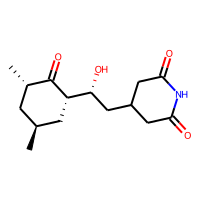
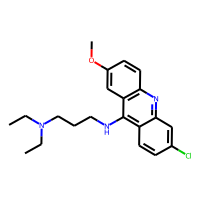
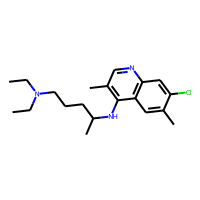
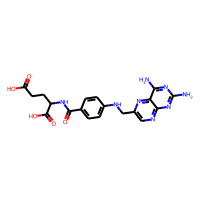
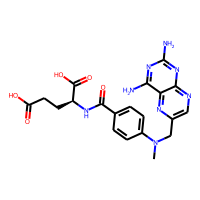
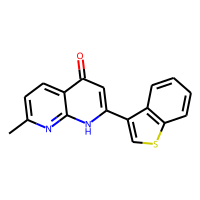
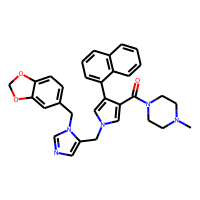
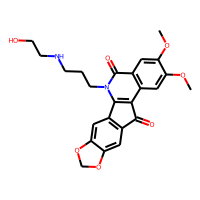
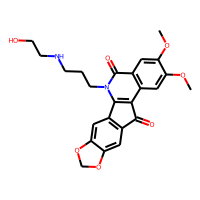
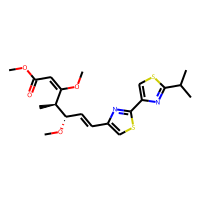

In [55]:
# Showing data above the upper limit
df6[df6['SR'] > sr_up_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive,,122.123,0.64070,0.0,2.0
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive,,319.533,6.60810,2.0,2.0
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive,,398.287,5.84610,0.0,0.0
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive,,177.247,1.82100,0.0,2.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active,,206.353,3.12648,0.0,0.0
...,...,...,...,...,...,...,...,...,...
40904,707041.0,c1cc(c(c(c1)Cl)C#N)Oc2ccc(cc2)S(=O)(=O)/N=C(/N...,4.6220,inactive,,520.578,5.70440,0.0,8.0
40905,707042.0,c1cc(c(c(c1)Cl)Oc2ccc(cc2)S(=O)(=O)/N=C(/Nc3cc...,5.2120,inactive,,450.462,4.98720,0.0,6.0
40906,707043.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,5.3960,inactive,,474.509,5.40730,0.0,7.0
40907,707044.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,4.9720,inactive,,654.665,1.57280,4.0,13.0

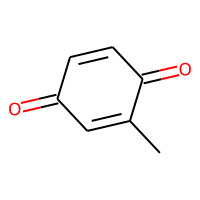
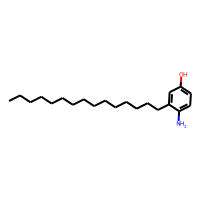
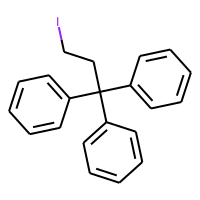
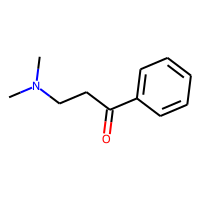
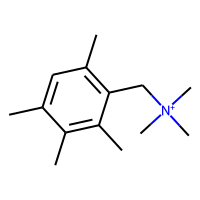
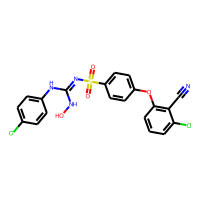
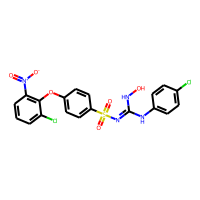
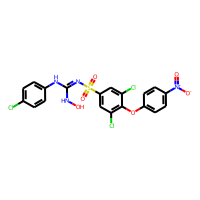
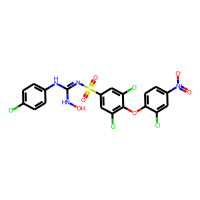
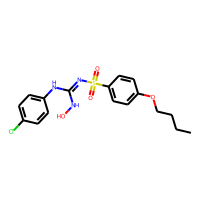

In [60]:
# Remove SR outlier
sr_no_outlier = df6[(df6['SR'] > sr_low_limit) & (df6['SR'] < sr_up_limit)]
sr_no_outlier

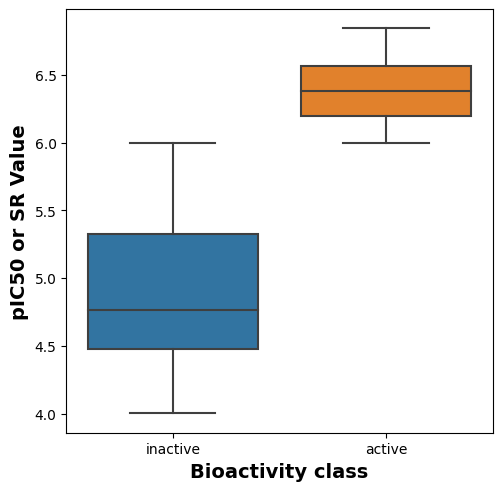

In [65]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'SR', data = sr_no_outlier)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('pIC50 or SR Value', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_sr_nooutlier.png')
plt.show()

In [63]:
mannwhitney('SR', sr_no_outlier)

,Descriptor,Statistics,p,alpha,Interpretation
0,SR,0.0,0.0,0.05,Different distribution (reject H0)


In [64]:
mannwhitney('SR', df6)

,Descriptor,Statistics,p,alpha,Interpretation
0,SR,0.0,0.0,0.05,Different distribution (reject H0)


## MW with Outlier

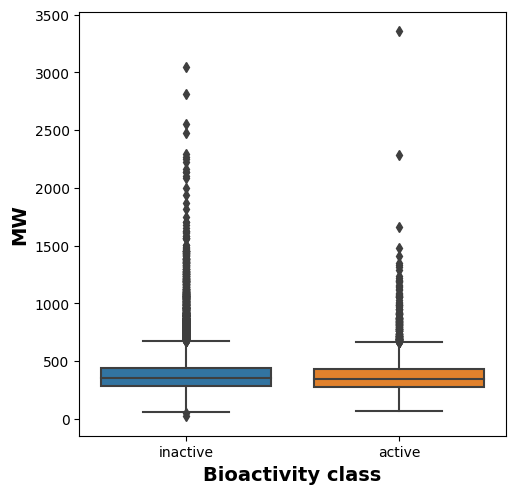

In [67]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df6)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('MW', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_mw.png')
plt.show()

## MW without outlier

In [76]:
# Percentile 5% on lower limit
mw_low_limit = df6['MW'].quantile(0.05)
print(mw_low_limit)

# Percentile 95% on upper limit
mw_up_limit = df6['MW'].quantile(0.95)
print(mw_up_limit)

201.27159999999998
646.4223999999999


,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive,,122.123,0.6407,0.0,2.0
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive,,177.247,1.8210,0.0,2.0
5,171.0,c1ccnc(c1)C(=O)O,4.0000,inactive,,123.111,0.7798,1.0,2.0
11,295.0,c1ccc(cc1)CCCC(=O)O,4.2730,inactive,,164.204,2.0939,1.0,1.0
21,534.0,c1ccc2c(c1)ccc3c2cccc3,5.6480,inactive,,86.090,-0.2160,0.0,2.0
...,...,...,...,...,...,...,...,...,...
39809,703448.0,CC(CN(C)C)CSc1nc2c(c(=N)n1c3ccccc3)c(=S)n(c(=S...,6.2530,active,,197.121,1.4043,0.0,4.0
39972,704083.0,COc1ccccc1CNC2=Nc3ccncc3S(=O)(=O)N2c4ccccc4,4.0330,inactive,,199.253,2.8192,1.0,2.0
40468,705319.0,CC1(CCN2C13CC4CCCC4(C2=O)S3)C,4.0000,inactive,,194.230,1.0191,1.0,3.0
40543,705845.0,CC1CNc2ccccc2N=C1NN,4.0000,inactive,,184.198,1.2945,1.0,2.0

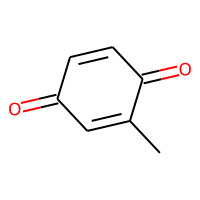
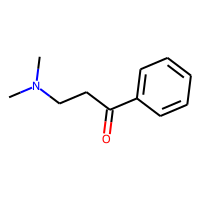
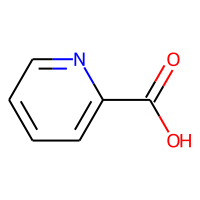
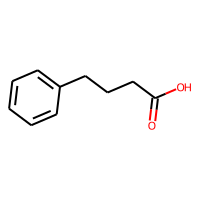
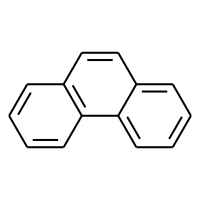
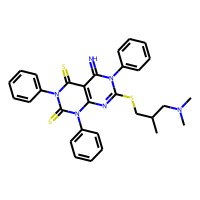
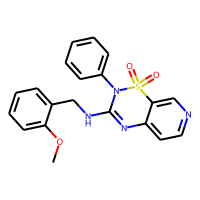
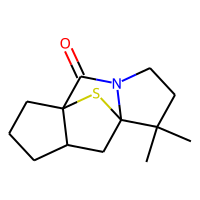
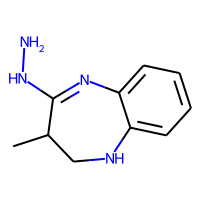
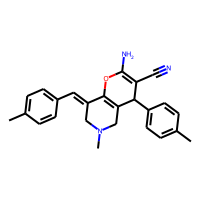

In [69]:
# Showing data below the lower limit
df6[df6['MW'] < mw_low_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
154,3074.0,CC1(N=C(N=C(N1c2ccc(cc2)Cl)N)N)C,4.689,inactive,,654.838,1.8880,9.0,11.0
224,4265.0,c1cc2ccc3cccnc3c2nc1,5.990,inactive,,740.968,7.6542,2.0,6.0
225,4271.0,c1cc(ccc1C(c2ccc(cc2)[N+](=O)[O-])Br)[N+](=O)[O-],5.627,inactive,,1701.206,4.8381,25.0,46.0
310,5485.0,c1cc2c(ccnc2cc1Cl)NCC(CNc3ccnc4c3ccc(c4)Cl)O,5.612,inactive,,673.800,1.3560,6.0,12.0
311,5491.0,CC[n+]1c(ccc2c1cccc2)/C=C/3\C=CN(c4c3cccc4)CC,6.819,active,,692.799,0.8380,7.0,13.0
...,...,...,...,...,...,...,...,...,...
40742,706211.0,CN1CC2C(N(N=C2/C(=C/c3cccs3)/C1)c4ccccc4)c5cccs5,5.766,inactive,,649.832,8.1024,3.0,6.0
40782,706448.0,c1ccc(cc1)S(=O)(=O)c2cc(sc2)S(=O)(=O)/N=C(/Nc3...,5.013,inactive,,646.737,4.8689,1.0,10.0
40791,706461.0,Cc1ccc2c(=O)cc([nH]c2n1)c3ccc(s3)c4ccccc4,5.614,inactive,,660.859,6.5024,2.0,5.0
40860,706845.0,Cn1c(nc2c1C(=O)C(=C(C2=O)c3[nH]c4c(n3)ccc(n4)N...,4.498,inactive,,738.850,2.6236,2.0,14.0

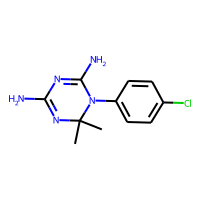
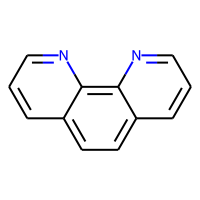
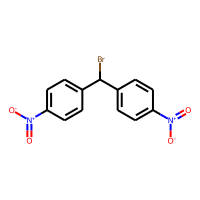
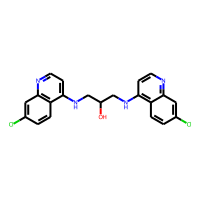
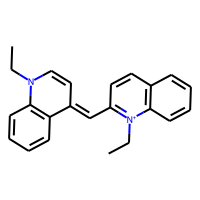
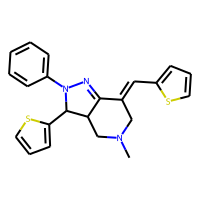
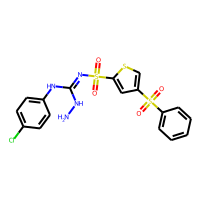
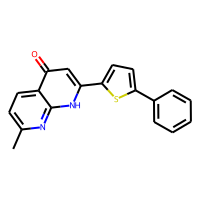
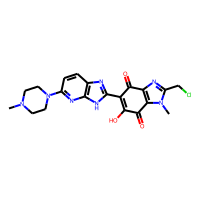
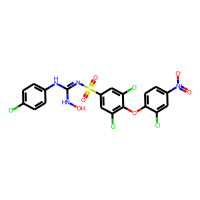

In [70]:
# Showing data above the upper limit
df6[df6['MW'] > mw_up_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.661,inactive,,319.533,6.60810,2.0,2.0
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.715,inactive,,398.287,5.84610,0.0,0.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.086,active,,206.353,3.12648,0.0,0.0
6,185.0,C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)...,7.381,active,,281.352,1.04150,2.0,4.0
7,186.0,C[C@@H]1[C@H](OC=C2C1=C(C(=O)C(=C2O)C(=O)O)C)C,4.806,inactive,,250.250,1.72100,2.0,4.0
...,...,...,...,...,...,...,...,...,...
40903,707040.0,c1ccc(cc1)S(=O)(=O)c2cc(sc2)S(=O)(=O)/N=C(/Nc3...,5.207,inactive,,465.456,5.53470,2.0,6.0
40904,707041.0,c1cc(c(c(c1)Cl)C#N)Oc2ccc(cc2)S(=O)(=O)/N=C(/N...,4.622,inactive,,520.578,5.70440,0.0,8.0
40905,707042.0,c1cc(c(c(c1)Cl)Oc2ccc(cc2)S(=O)(=O)/N=C(/Nc3cc...,5.212,inactive,,450.462,4.98720,0.0,6.0
40906,707043.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,5.396,inactive,,474.509,5.40730,0.0,7.0

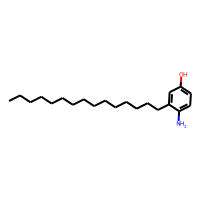
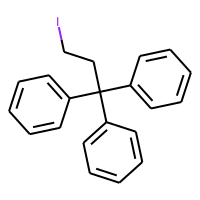
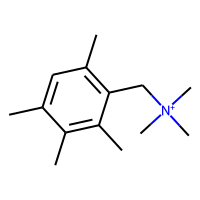
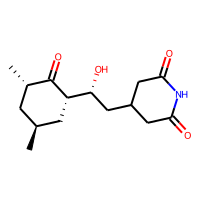
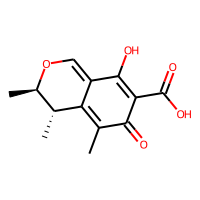
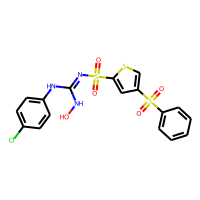
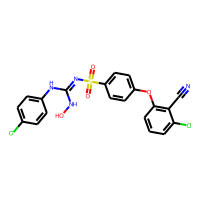
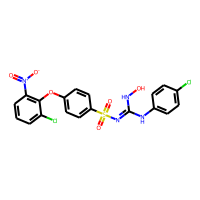
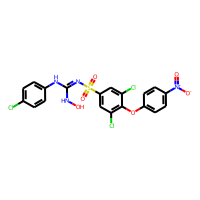
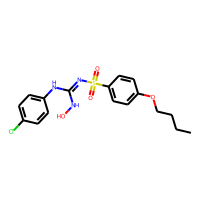

In [71]:
# Remove SR outlier
mw_no_outlier = df6[(df6['MW'] > mw_low_limit) & (df6['MW'] < mw_up_limit)]
mw_no_outlier

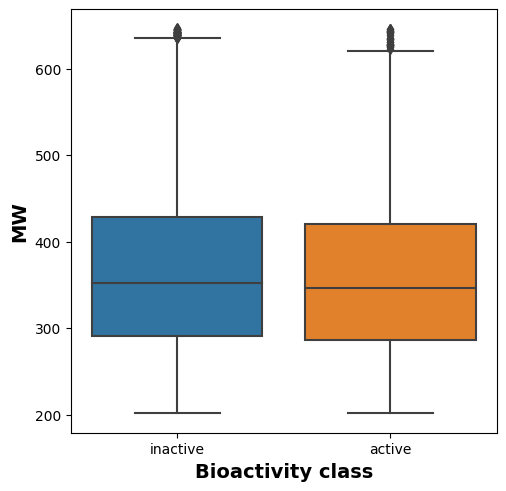

In [72]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = mw_no_outlier)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('MW', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_mw_nooutlier.png')
plt.show()

In [73]:
mannwhitney('MW', mw_no_outlier)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,38891745.5,0.003058,0.05,Different distribution (reject H0)


In [74]:
mannwhitney('MW', df6)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,48507007.0,0.000406,0.05,Different distribution (reject H0)


## LogP with Outlier

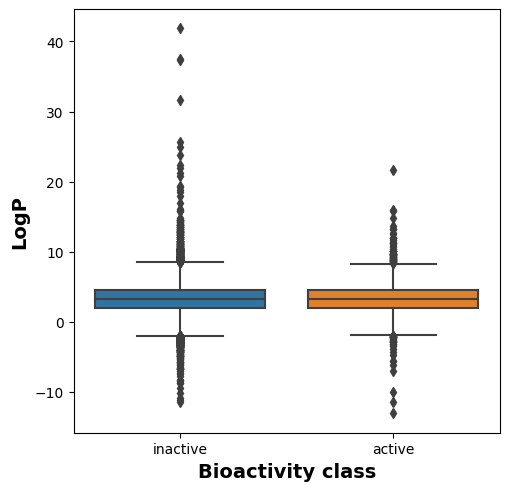

In [75]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df6)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_logp.png')
plt.show()

## LogP without Outlier

In [78]:
# Percentile 5% on lower limit
logp_low_limit = df6['LogP'].quantile(0.05)
print(logp_low_limit)

# Percentile 95% on upper limit
logp_up_limit = df6['LogP'].quantile(0.95)
print(logp_up_limit)

-0.2965549999999999
6.801717000000004


,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
26,738.0,CC(C)(C)CC(C)(C)c1ccc(cc1)OCCOCCSC(=N)N,5.970,inactive,,152.117,-1.3766,3.0,5.0
63,1451.0,Cn1c2c(cn1)c(ncn2)NCc3ccccc3,4.000,inactive,,238.192,-4.2914,6.0,8.0
64,1460.0,c1ccc2c(c1)c(n[nH]2)CC(C(=O)O)N,4.000,inactive,,194.139,-3.2849,5.0,6.0
74,1694.0,C(C(=O)C(C(C(C(=O)O)O)O)O)O,4.000,inactive,,101.065,-1.6087,3.0,2.0
76,1771.0,CN(C)C(=S)SSC(=S)N(C)C,4.925,inactive,,99.097,-1.0309,3.0,4.0
...,...,...,...,...,...,...,...,...,...
39706,703122.0,c1ccc2c(c1)c3c([nH]2)C(CCC3)c4ccc(c(c4)N)O,5.349,inactive,,243.288,-0.8172,3.0,7.0
39752,703194.0,CC(C)(CNC(=O)CCCC(=O)N(C)O)CNC(=O)CCCC(=O)N(C)O,4.000,inactive,,269.217,-2.8739,4.0,9.0
40164,704561.0,CCCCn1c-2c(n(c1=S)CCCC)SSc3c(n(c(=S)n3CCCC)CCC...,5.726,inactive,,553.509,-0.6454,5.0,7.0
40721,706189.0,c1ccc2c(c1)C(=O)Sc3ccc(cc3C(=O)S2)Br,5.975,inactive,,273.248,-0.3300,2.0,5.0

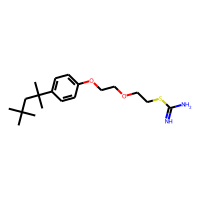
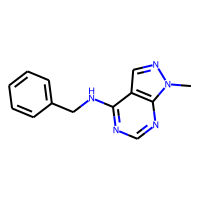
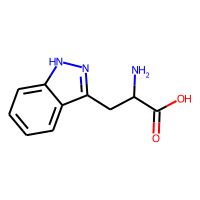
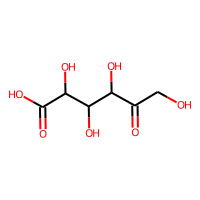
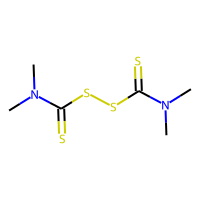
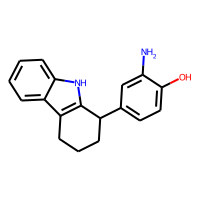
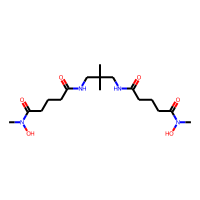
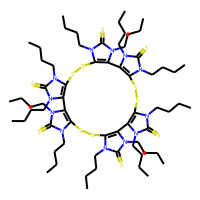
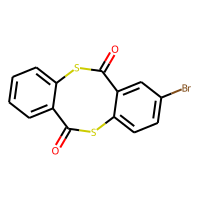
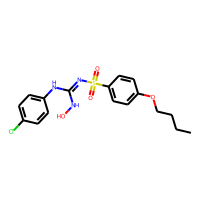

In [79]:
# Showing data below the lower limit
df6[df6['LogP'] < logp_low_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
88,1906.0,C1CCN(CC1)C(=S)S,5.062667,inactive,,374.677,8.18810,0.0,0.0
93,1938.0,C1CNC(=S)N1,4.000000,inactive,,488.630,8.97180,1.0,1.0
148,3060.0,O[As]=O,4.723000,inactive,,487.322,7.32140,0.0,1.0
158,3081.0,CCCCCCC1N=C(N=C(N1c2ccc(cc2)Cl)N)N,5.524000,inactive,,356.664,7.18630,1.0,2.0
159,3082.0,CC1(N=C(N=C(N1c2cccc(c2)Br)N)N)C,6.153000,active,,456.667,7.89020,2.0,4.0
...,...,...,...,...,...,...,...,...,...
40742,706211.0,CN1CC2C(N(N=C2/C(=C/c3cccs3)/C1)c4ccccc4)c5cccs5,5.766000,inactive,,649.832,8.10240,3.0,6.0
40743,706212.0,CN1CC2C(NC(=S)N=C2/C(=C/c3cccs3)/C1)c4cccs4,4.739000,inactive,,621.778,7.32220,3.0,6.0
40744,706213.0,CN1C/C(=C\c2cccs2)/C3=C(C1)C(C(=C(O3)N)C#N)c4c...,5.380000,inactive,,616.438,8.54658,0.0,3.0
40790,706460.0,Cc1ccc2c(=O)cc([nH]c2n1)Cc3cccc(c3)OC,4.446000,inactive,,539.595,7.36252,0.0,8.0

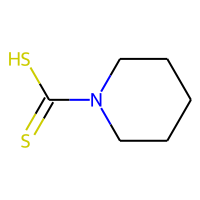
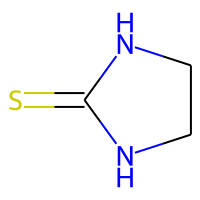
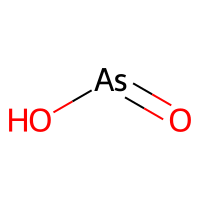
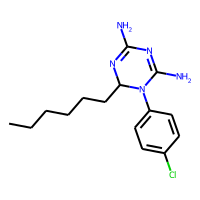
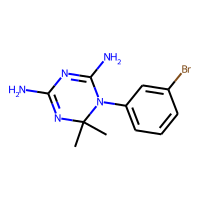
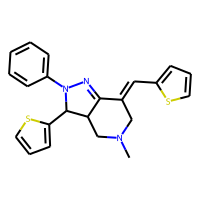
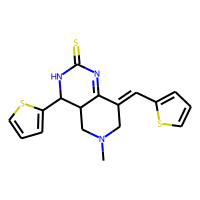
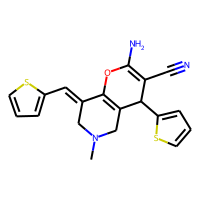
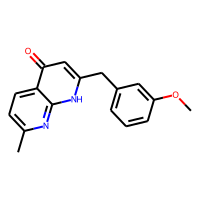
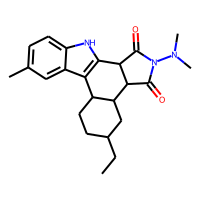

In [80]:
# Showing data above the upper limit
df6[df6['LogP'] > logp_up_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
0,1.0,CC1=CC(=O)C=CC1=O,5.4095,inactive,,122.123,0.64070,0.0,2.0
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.6610,inactive,,319.533,6.60810,2.0,2.0
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.7150,inactive,,398.287,5.84610,0.0,0.0
3,89.0,CN(C)CCC(=O)c1ccccc1,4.4550,inactive,,177.247,1.82100,0.0,2.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.0860,active,,206.353,3.12648,0.0,0.0
...,...,...,...,...,...,...,...,...,...
40903,707040.0,c1ccc(cc1)S(=O)(=O)c2cc(sc2)S(=O)(=O)/N=C(/Nc3...,5.2070,inactive,,465.456,5.53470,2.0,6.0
40904,707041.0,c1cc(c(c(c1)Cl)C#N)Oc2ccc(cc2)S(=O)(=O)/N=C(/N...,4.6220,inactive,,520.578,5.70440,0.0,8.0
40905,707042.0,c1cc(c(c(c1)Cl)Oc2ccc(cc2)S(=O)(=O)/N=C(/Nc3cc...,5.2120,inactive,,450.462,4.98720,0.0,6.0
40906,707043.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,5.3960,inactive,,474.509,5.40730,0.0,7.0

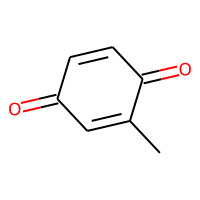
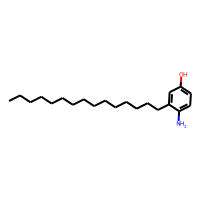
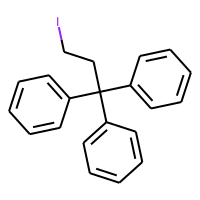
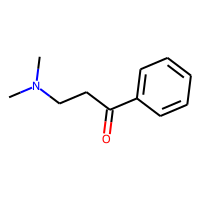
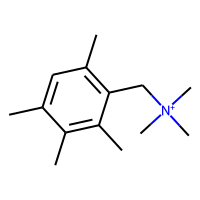
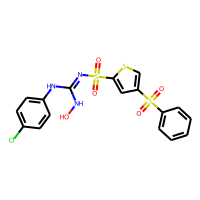
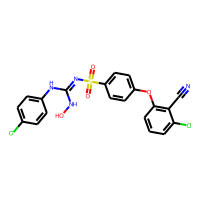
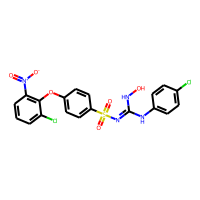
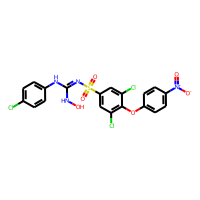
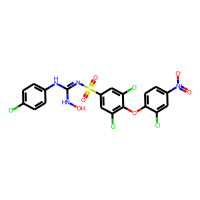

In [86]:
# Remove SR outlier
logp_no_outlier = df6[(df6['LogP'] > logp_low_limit) & (df6['LogP'] < logp_up_limit)]
logp_no_outlier

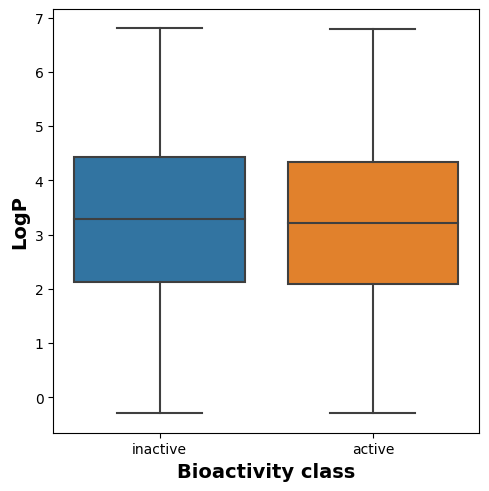

In [87]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = logp_no_outlier)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('LogP', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_logp_nooutlier.png')
plt.show()

In [88]:
mannwhitney('LogP', logp_no_outlier)

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,39709363.5,0.021455,0.05,Different distribution (reject H0)


In [89]:
mannwhitney('LogP', df6)

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,49259459.0,0.028922,0.05,Different distribution (reject H0)


## NumHDonors with Outlier

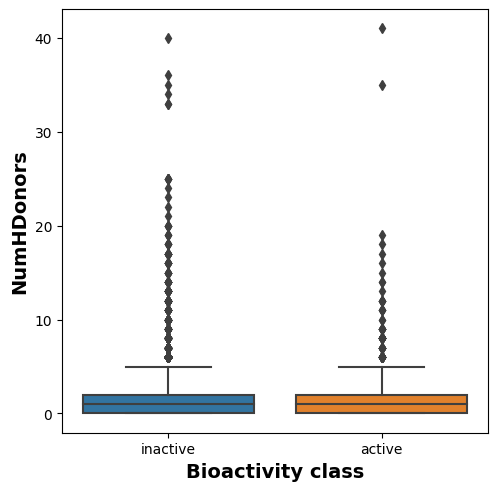

In [90]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df6)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHDonors', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_numhdonors.png')
plt.show()

## NumHDonors without Outlier

In [91]:
# Percentile 5% on lower limit
hdonors_low_limit = df6['NumHDonors'].quantile(0.05)
print(hdonors_low_limit)

# Percentile 95% on upper limit
hdonors_up_limit = df6['NumHDonors'].quantile(0.95)
print(hdonors_up_limit)

0.0
4.0


In [93]:
# Showing data below the lower limit
df6[df6['NumHDonors'] < hdonors_low_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors


,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
24,629.0,C1C(O1)C2CO2,5.411,inactive,,440.420,0.24410,6.0,10.0
25,721.0,c1ccc2c(c1)/C(=N/NC(=S)N)/C(=O)N2,4.008,inactive,,454.447,0.26840,5.0,10.0
63,1451.0,Cn1c2c(cn1)c(ncn2)NCc3ccccc3,4.000,inactive,,238.192,-4.29140,6.0,8.0
64,1460.0,c1ccc2c(c1)c(n[nH]2)CC(C(=O)O)N,4.000,inactive,,194.139,-3.28490,5.0,6.0
84,1892.0,c1(=O)[nH]c(=O)[nH][nH]1,4.000,inactive,,196.155,-3.49310,6.0,6.0
...,...,...,...,...,...,...,...,...,...
40163,704560.0,CCCOc1c2cc(cc1Cc3cc(cc(c3OCCC)Cc4cc(cc(c4OCCC)...,4.861,inactive,,650.025,1.18830,5.0,7.0
40164,704561.0,CCCCn1c-2c(n(c1=S)CCCC)SSc3c(n(c(=S)n3CCCC)CCC...,5.726,inactive,,553.509,-0.64540,5.0,7.0
40322,704873.0,c1ccc(cc1)NNC2=N/C(=C\c3ccccc3O)/C(=O)N2,4.000,inactive,,463.516,0.98682,6.0,8.0
40687,706154.0,Cc1ccc(cc1)C(=O)N/N=C(\c2ccc(cc2OC)N(CCC#N)CCC...,4.436,inactive,,471.561,5.00740,5.0,4.0

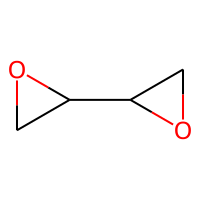
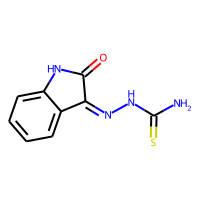
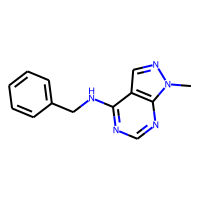
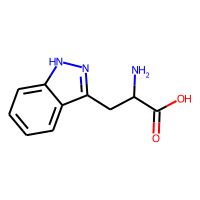
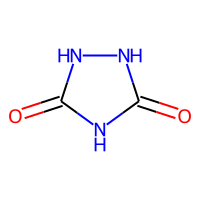
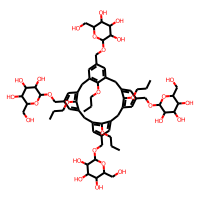
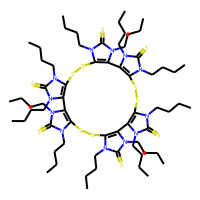
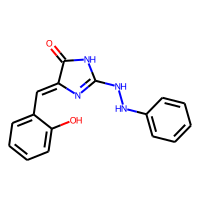
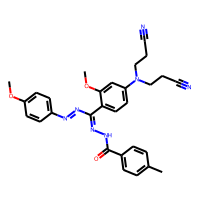
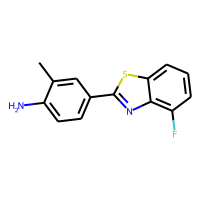

In [94]:
# Showing data above the upper limit
df6[df6['NumHDonors'] > hdonors_up_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
1,17.0,CCCCCCCCCCCCCCCc1cc(ccc1N)O,5.661,inactive,,319.533,6.60810,2.0,2.0
5,171.0,c1ccnc(c1)C(=O)O,4.000,inactive,,123.111,0.77980,1.0,2.0
6,185.0,C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)...,7.381,active,,281.352,1.04150,2.0,4.0
7,186.0,C[C@@H]1[C@H](OC=C2C1=C(C(=O)C(=C2O)C(=O)O)C)C,4.806,inactive,,250.250,1.72100,2.0,4.0
11,295.0,c1ccc(cc1)CCCC(=O)O,4.273,inactive,,164.204,2.09390,1.0,1.0
...,...,...,...,...,...,...,...,...,...
40894,707031.0,c1ccc(cc1)S(=O)(=O)/N=C(/Nc2ccc(cc2)Cl)\NO,5.938,inactive,,393.899,5.66730,2.0,4.0
40900,707037.0,c1ccnc(c1)c2ccc(s2)S(=O)(=O)/N=C(/Nc3ccc(cc3)C...,4.000,inactive,,485.558,4.70622,2.0,7.0
40901,707038.0,c1cc(ccc1N/C(=N/S(=O)(=O)C2CC=C(S2)c3ccon3)/NO)Cl,5.639,inactive,,520.003,5.35420,1.0,7.0
40903,707040.0,c1ccc(cc1)S(=O)(=O)c2cc(sc2)S(=O)(=O)/N=C(/Nc3...,5.207,inactive,,465.456,5.53470,2.0,6.0

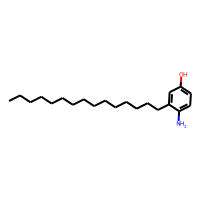
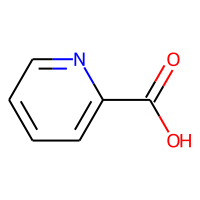
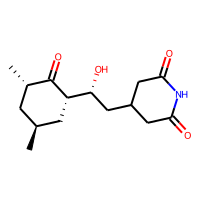
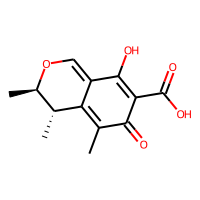
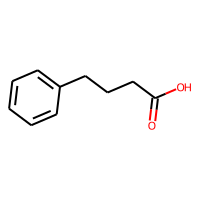
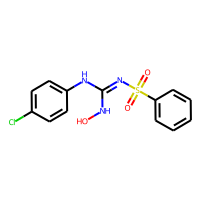
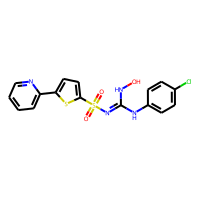
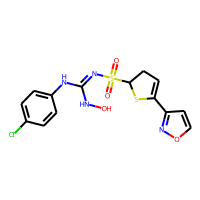
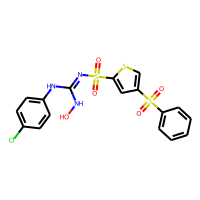
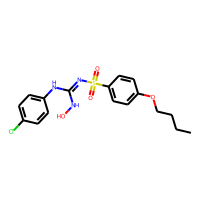

In [95]:
# Remove NumHDonors outlier
hdonors_no_outlier = df6[(df6['NumHDonors'] > hdonors_low_limit) & (df6['NumHDonors'] < hdonors_up_limit)]
hdonors_no_outlier

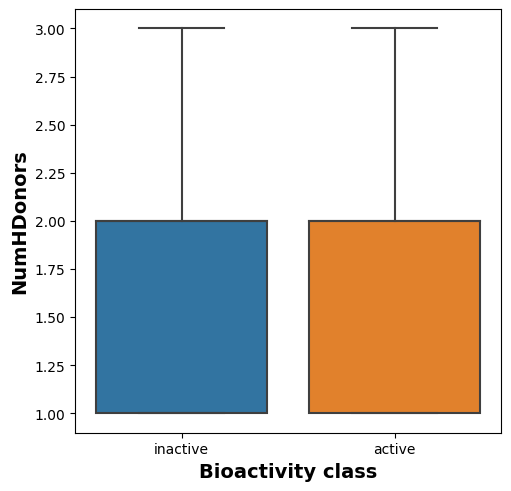

In [96]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = hdonors_no_outlier)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHDonors', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_hdonors_nooutlier.png')
plt.show()

In [97]:
mannwhitney('NumHDonors', hdonors_no_outlier)

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,18227794.5,0.201237,0.05,Same distribution (fail to reject H0)


In [98]:
mannwhitney('NumHDonors', df6)

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,49566982.5,0.088904,0.05,Same distribution (fail to reject H0)


## NumHAcceptors with Outlier

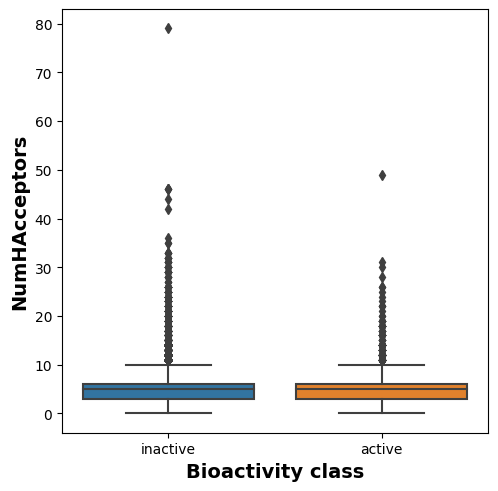

In [99]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df6)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_numhacceptors.png')
plt.show()

## NumHAcceptors without Outlier

In [100]:
# Percentile 5% on lower limit
hacceptors_low_limit = df6['NumHAcceptors'].quantile(0.05)
print(hacceptors_low_limit)

# Percentile 95% on upper limit
hacceptors_up_limit = df6['NumHAcceptors'].quantile(0.95)
print(hacceptors_up_limit)

2.0
11.0


,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
2,26.0,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.715,inactive,,398.287,5.84610,0.0,0.0
4,112.0,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.086,active,,206.353,3.12648,0.0,0.0
11,295.0,c1ccc(cc1)CCCC(=O)O,4.273,inactive,,164.204,2.09390,1.0,1.0
19,479.0,c1ccc(cc1)CC2(C(=O)NC(=O)N2)c3cccnc3,4.000,inactive,,279.100,-0.20460,0.0,0.0
31,750.0,CS(=O)(=O)OCCCCOS(=O)(=O)C,4.028,inactive,,156.056,1.39580,0.0,1.0
...,...,...,...,...,...,...,...,...,...
39304,701635.0,CCOC(=O)c1c(c(c(=O)[nH]c1N2CCCC2)C(c3ccc(cc3)O...,4.051,inactive,,277.496,5.29540,1.0,1.0
39353,701735.0,c1cc(ccc1C(=O)c2c(c3c(s2)NC(=O)C(C34CCCCC4)C#N...,5.099,inactive,,306.236,5.17960,1.0,1.0
39675,703081.0,CC1C(C(C(C(O1)Oc2c(=O)c3c(cc(cc3oc2c4ccc(cc4)O...,4.513,inactive,,339.192,4.42310,2.0,1.0
39738,703169.0,c1ccc2c(c1)C(=O)O[S+2]23c4cccc5c4c(ccc5)CO3,4.000,inactive,,295.813,5.47364,0.0,1.0

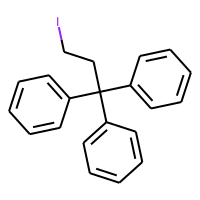
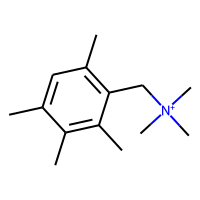
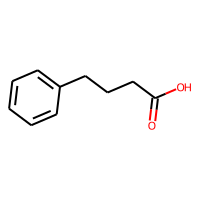
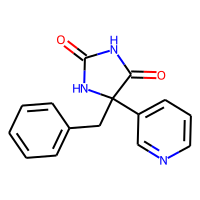
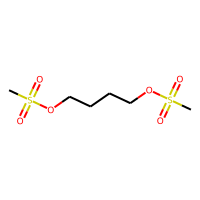
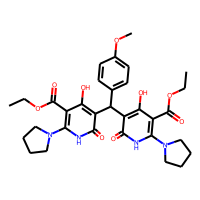
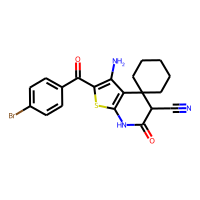
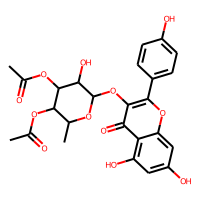
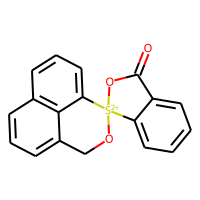
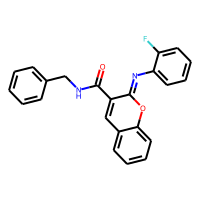

In [102]:
# Showing data below the lower limit
df6[df6['NumHAcceptors'] < hacceptors_low_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
225,4271.0,c1cc(ccc1C(c2ccc(cc2)[N+](=O)[O-])Br)[N+](=O)[O-],5.627,inactive,,1701.206,4.83810,25.0,46.0
252,4622.0,CC(C)(C)COS(=O)OCC(C)(C)C,4.000,inactive,,580.539,-1.16520,8.0,14.0
309,5477.0,CC(=O)C(C(c1ccccc1)N2CCOCC2)N3CCOCC3,4.076,inactive,,620.692,0.64270,6.0,12.0
310,5485.0,c1cc2c(ccnc2cc1Cl)NCC(CNc3ccnc4c3ccc(c4)Cl)O,5.612,inactive,,673.800,1.35600,6.0,12.0
311,5491.0,CC[n+]1c(ccc2c1cccc2)/C=C/3\C=CN(c4c3cccc4)CC,6.819,active,,692.799,0.83800,7.0,13.0
...,...,...,...,...,...,...,...,...,...
39790,703327.0,COc1c(ccc(c1)/C=C/c2oc(cc(=O)c2)/C=C/c3cc(c(cc...,4.628,inactive,,963.098,0.80894,8.0,18.0
40736,706205.0,Cc1ccc(cc1)/C=C/2\CN(CC3C2=NC(=S)NC3c4ccc(cc4)C)C,4.525,inactive,,810.989,4.02830,3.0,12.0
40860,706845.0,Cn1c(nc2c1C(=O)C(=C(C2=O)c3[nH]c4c(n3)ccc(n4)N...,4.498,inactive,,738.850,2.62360,2.0,14.0
40861,706965.0,C(CNC1C(C(C(C(O1)CO)O)O)O)NCCNC2C(C(C(C(O2)CO)...,4.000,inactive,,626.722,2.30220,2.0,12.0

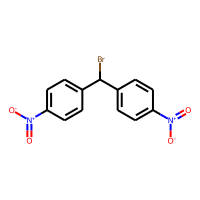
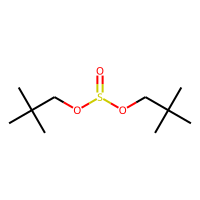
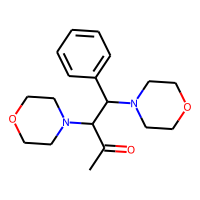
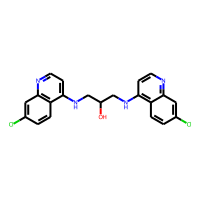
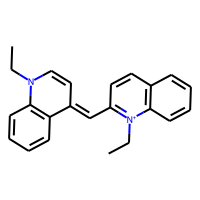
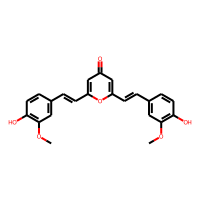
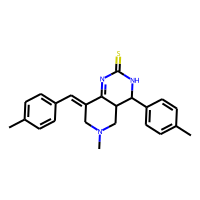
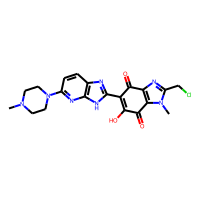
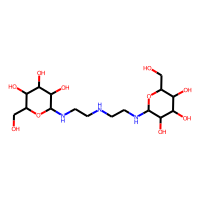
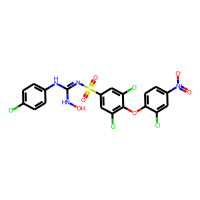

In [103]:
# Showing data above the upper limit
df6[df6['NumHAcceptors'] > hacceptors_up_limit]

,molecule_id,Washed_smiles,SR,bioactivity_class,ROMol,MW,LogP,NumHDonors,NumHAcceptors
6,185.0,C[C@H]1C[C@@H](C(=O)[C@@H](C1)[C@@H](CC2CC(=O)...,7.381,active,,281.352,1.04150,2.0,4.0
7,186.0,C[C@@H]1[C@H](OC=C2C1=C(C(=O)C(=C2O)C(=O)O)C)C,4.806,inactive,,250.250,1.72100,2.0,4.0
10,291.0,c1ccc(cc1)/C=C\2/C(=O)OC(=N2)c3ccccc3,4.838,inactive,,249.269,3.03110,0.0,3.0
12,353.0,CCN(CC)CCCNc1c2ccc(cc2nc3c1cc(cc3)OC)Cl,7.538,active,,371.912,5.19380,1.0,4.0
13,355.0,CCN(CC)CCCC(C)Nc1c(cnc2c1cc(c(c2)Cl)C)C,8.000,active,,347.934,5.42744,1.0,3.0
...,...,...,...,...,...,...,...,...,...
40903,707040.0,c1ccc(cc1)S(=O)(=O)c2cc(sc2)S(=O)(=O)/N=C(/Nc3...,5.207,inactive,,465.456,5.53470,2.0,6.0
40904,707041.0,c1cc(c(c(c1)Cl)C#N)Oc2ccc(cc2)S(=O)(=O)/N=C(/N...,4.622,inactive,,520.578,5.70440,0.0,8.0
40905,707042.0,c1cc(c(c(c1)Cl)Oc2ccc(cc2)S(=O)(=O)/N=C(/Nc3cc...,5.212,inactive,,450.462,4.98720,0.0,6.0
40906,707043.0,c1cc(ccc1N/C(=N/S(=O)(=O)c2cc(c(c(c2)Cl)Oc3ccc...,5.396,inactive,,474.509,5.40730,0.0,7.0

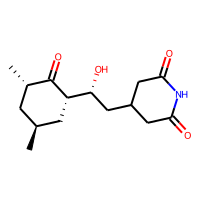
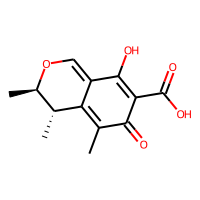
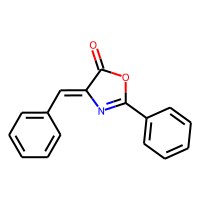
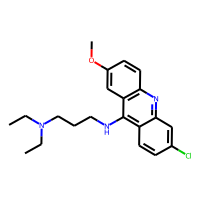
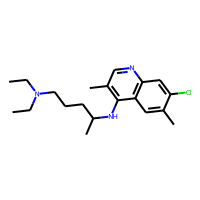
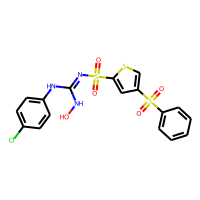
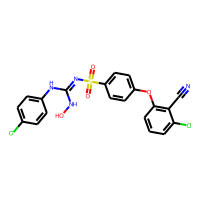
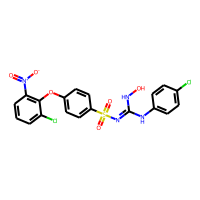
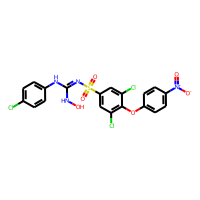
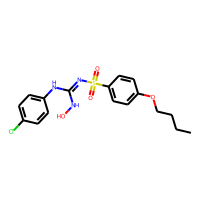

In [104]:
# Remove NumHAcceptors outlier
hacceptors_no_outlier = df6[(df6['NumHAcceptors'] > hacceptors_low_limit) & (df6['NumHAcceptors'] < hacceptors_up_limit)]
hacceptors_no_outlier

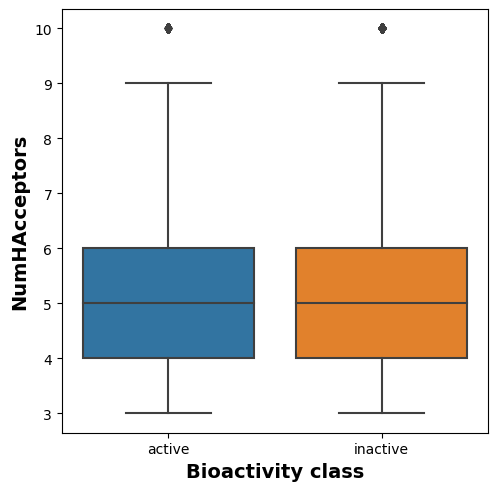

In [105]:
plt.figure(figsize = (5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = hacceptors_no_outlier)

plt.xlabel('Bioactivity class', fontsize = 14, fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontsize = 14, fontweight = 'bold')

plt.savefig('boxplot_hacceptors_nooutlier.png')
plt.show()

In [106]:
mannwhitney('NumHAcceptors', hacceptors_no_outlier)

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,32088783.0,0.078925,0.05,Same distribution (fail to reject H0)


In [107]:
mannwhitney('NumHAcceptors', df6)

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,48563777.5,0.000542,0.05,Different distribution (reject H0)


# Model Building

In [111]:
# https://ivanongko.medium.com/teknik-resampling-untuk-data-tidak-seimbang-5d566661101c

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [117]:
selection = ['SR', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
df7 = df6[selection]
df7

,SR,MW,LogP,NumHDonors,NumHAcceptors
0,5.4095,122.123,0.64070,0.0,2.0
1,5.6610,319.533,6.60810,2.0,2.0
2,5.7150,398.287,5.84610,0.0,0.0
3,4.4550,177.247,1.82100,0.0,2.0
4,6.0860,206.353,3.12648,0.0,0.0
...,...,...,...,...,...
40904,4.6220,520.578,5.70440,0.0,8.0
40905,5.2120,450.462,4.98720,0.0,6.0
40906,5.3960,474.509,5.40730,0.0,7.0
40907,4.9720,654.665,1.57280,4.0,13.0


In [137]:
df7 = np.array(df7).astype(int)
infeatures = df7
outfeatures = df6.bioactivity_class
#df7

In [138]:
X_train, X_test, y_train, y_test = train_test_split(infeatures, outfeatures, train_size=0.75, test_size=0.25, random_state=0)

In [139]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
y_rf_pred = model.predict(X_test)
print('Accuracy is ', accuracy_score(y_test, y_rf_pred))
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Accuracy is  1.0
Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [154]:
print("Training Data")
print("Number of active molecules: ", list(y_train).count('active'))
print("Number of inactive molecules: ", list(y_train).count('inactive'))
print("Test Data")
print("Number of active molecules: ", list(y_test).count('active'))
print("Number of inactive molecules: ", list(y_test).count('inactive'))

Training Data
Number of active molecules:  2637
Number of inactive molecules:  21418
Test Data
Number of active molecules:  882
Number of inactive molecules:  7137


In [167]:
print("X_train.shape is: ", X_train.shape)
print("X_test.shape is: ", X_test.shape)
print("y_train.shape is: ", y_train.shape)
print("y_test.shape is: ", y_test.shape)

X_train.shape is:  (24055, 5)
X_test.shape is:  (8019, 5)
y_train.shape is:  (24055,)
y_test.shape is:  (8019,)


In [158]:
clf = LogisticRegression(random_state=13)
clf.fit(X_train, y_train)
y_lr_pred = clf.predict(X_test)
print('Accuracy is ', accuracy_score(y_test, y_lr_pred))

Accuracy is  1.0


              precision    recall  f1-score   support

      active       1.00      1.00      1.00       882
    inactive       1.00      1.00      1.00      7137

    accuracy                           1.00      8019
   macro avg       1.00      1.00      1.00      8019
weighted avg       1.00      1.00      1.00      8019



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

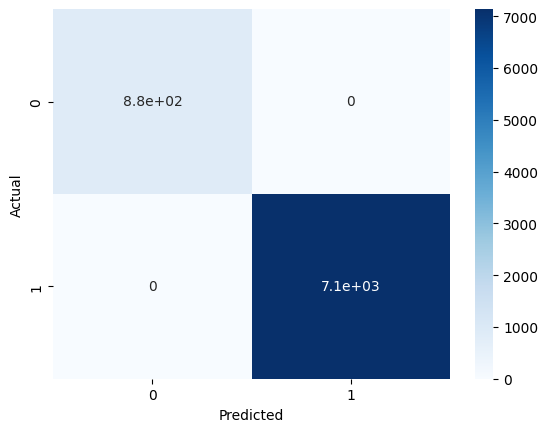

In [159]:
print(classification_report(y_test, y_lr_pred))
cf_matrix = confusion_matrix(y_test, y_lr_pred)
df_cm = pd.DataFrame(cf_matrix, columns=['0', '1'], index=['0', '1'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap='Blues', annot=True)

              precision    recall  f1-score   support

      active       1.00      1.00      1.00       882
    inactive       1.00      1.00      1.00      7137

    accuracy                           1.00      8019
   macro avg       1.00      1.00      1.00      8019
weighted avg       1.00      1.00      1.00      8019



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

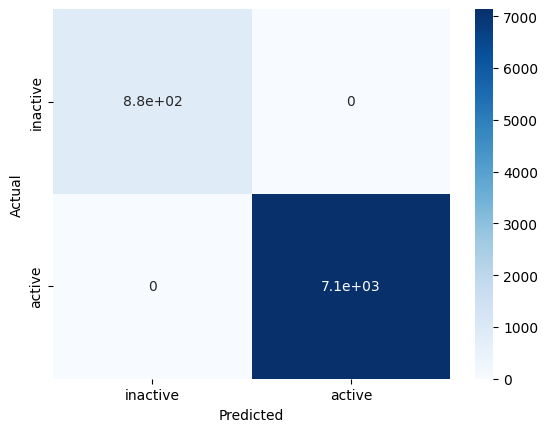

In [160]:
print(classification_report(y_test, y_rf_pred))
cf_matrix_rf = confusion_matrix(y_test, y_rf_pred)
df_cm = pd.DataFrame(cf_matrix_rf, columns=['inactive', 'active'], index=['inactive', 'active'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap='Blues', annot=True)

In [161]:
sm = SMOTE(random_state=13)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Original dataset shape is ', Counter(y_train))
print('Resample dataset shape is ', Counter(y_res))

Original dataset shape is  Counter({'inactive': 21418, 'active': 2637})
Resample dataset shape is  Counter({'inactive': 21418, 'active': 21418})


In [162]:
clf_new = LogisticRegression(random_state=13)
clf_new.fit(X_res, y_res)
y_lrnew_pred = clf_new.predict(X_test)
print('Accuracy is ', accuracy_score(y_test, y_lrnew_pred))

Accuracy is  1.0


/Users/alqaafsubando-m/opt/anaconda3/envs/pbl-1/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

      active       1.00      1.00      1.00       882
    inactive       1.00      1.00      1.00      7137

    accuracy                           1.00      8019
   macro avg       1.00      1.00      1.00      8019
weighted avg       1.00      1.00      1.00      8019



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

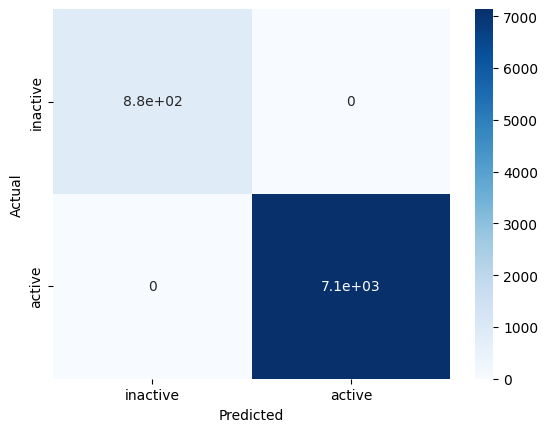

In [163]:
print(classification_report(y_test, y_lrnew_pred))
cf_matrix_new = confusion_matrix(y_test, y_lrnew_pred)
df_cm_new = pd.DataFrame(cf_matrix, columns=['inactive', 'active'], index=['inactive', 'active'])
df_cm_new.index.name = 'Actual'
df_cm_new.columns.name = 'Predicted'
sns.heatmap(df_cm_new, cmap='Blues', annot=True)

## Cross-validation

In [174]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [171]:
# Perform 6-fold cross validation
scores = cross_val_score(model, infeatures, outfeatures, cv=6)
print("Cross-validated scores: ", scores)

Cross-validated scores:  [1. 1. 1. 1. 1. 1.]


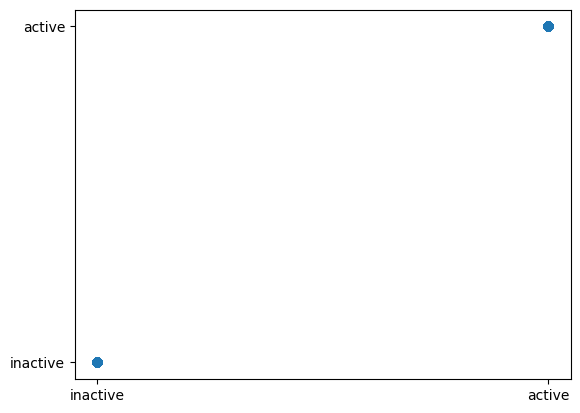

In [172]:
# Make cross validated predictions
predictions = cross_val_predict(model, infeatures, outfeatures, cv=6)
plt.scatter(outfeatures, predictions)